# 第9章 自然语言处理

## 9.1 语言模型的背景知识

### 9.1.1 语言模型简介

- 假设一门语言中所有可能的句子服从某一个概率分布，每个句子出现的概率加起来为1，那么“语言模型”的任务就是预测每个句子在语言中出现的概率；对于语言中常见的句子，一个好的语言模型应得出相对较高的概率，而对于不合语法的句子，计算出的概率则应接近于0；把句子看成单词的序列，语言模型可以表示为一个计算$p(w_1, w_2, w_3, \dots, w_m)$的模型
- 语言模型有很多应用，很多生成自然语言文本的应用都依赖语言模型来优化输出文本的流畅性；例如，在输入法中，利用语言模型比较候选的概率；在统计机器翻译的噪声信道模型中，每个候选翻译的概率由一个翻译模型和一个语言模型共同决定，其中的语言模型就起到了在目标语言中挑选较为合理句子的作用；神经网络机器翻译的Seq2Seq模型可以看作是一个条件语言模型，它相当于是在给定输入的情况下对目标语言所有句子估算概率，并选择其中概率最大的句子作为输出
- 常见的语言模型建模方法有n-gram、决策树、最大熵、CRF、神经网络等；n-gram模型的参数一般采用MLE方法估算，训练语料的规模越大，参数估计的结果越可靠，但即使训练数据的规模非常大时，还是有很多单词序列在训练语料中不会出现，因此训练时会使用一些平滑方法

### 9.1.2 语言模型的评价方法

- 语言模型效果好坏的常用评价指标是复杂度（perplexity），在一个测试集上得到的perplexity越低，说明建模的效果越好，计算perplexity值的公式如下：
$$perplexity(S)=p(w_1,w_2,w_3,\cdots,w_m)^{-1/m}=\sqrt[m]{\frac{1}{p(w_1,w_2,w_3,\cdots,w_m)}}=\sqrt[m]{\prod_{i=1}^{m}\frac{1}{p(w_i|w_1,\cdots,w_{i-1})}}$$
- 简单来说，perplexity值刻画的是语言模型预测一个语言样本的能力，比如已经知道$(w_1,w_2,w_3,\cdots,w_m)$这句话会出现在语料库之中，那么语言模型计算得到这句话的概率越高，说明语料库对这个语料库拟合得越好
- perplexity可以理解为平均分支系数（average branching factor），即模型预测下一个词时的平均可选择数量
- 在语言模型的训练中，通常采用perplexity的对数表达形式：
$$\log ({perplexity(S)}) = -\frac{1}{m}\sum_{i=1}^{m}\log {p(w_i|w_1,\cdots,w_{i-1})}$$
- 相比乘积求平方根的方式，使用加法的形式可以加速计算，同时避免概率乘积数值过小而导致浮点数向下溢出的问题；在数学上，log perplexity可以看成真实分布与预测分布之间的交叉熵
- 在神经网络模型中，$p(w_i|w_1,w_2.\cdots,w_{i-1})$分布通常是由一个softmax层产生的，这时TensorFlow中提供了两个方便计算交叉熵的函数：tf.nn.softmax_cross_entropy_with_logits和tf.nn.sparse_softmax_cross_entropy_with_logits，两个函数的区别可看下面的例子

In [5]:
import tensorflow as tf

# 假设词汇表的大小为3，语料包含两个单词“2 0”
word_labels = tf.constant([2, 0])

# 假设模型对两个单词预测时，产生的logit分别是[2.0, -1.0, 3.0]和[1.0, 0.0, -0.5]；注意这里的logit不是概率，因此它们不是0.0~1.0范围之间的数字，如果需要计算概率，则需要调用prob=tf.nn.softmax(logits)，但这里计算交叉熵的函数直接输入logits即可
predict_logits = tf.constant([[2.0, -1.0, 3.0], [1.0, 0.0, -0.5]])

# 使用sparse_softmax_cross_entropy_with_logits计算交叉熵
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=word_labels, logits=predict_logits)

# 运行程序，计算loss的结果是[0.32656264, 0.46436879]，这对应两个预测的perplexity损失
sess = tf.Session()
sess.run(loss)

# softmax_cross_entropy_with_logits与上面的函数相似，但是需要将预测目标以概率分布的形式给出
word_prob_distribution = tf.constant([[0.0, 0.0, 1.0], [1.0, 0.0, 0.0]])
loss = tf.nn.softmax_cross_entropy_with_logits(labels=word_prob_distribution, logits=predict_logits)
# 运行结果与上面相同：[0.32656264, 0.46436879]
sess.run(loss)

# 由于softmax_cross_entropy_with_logits允许提供一个概率分布，因此在使用时有更大的自由度；举个例子，一种叫label smoothing的技巧是将正确数据的概率设为一个比1.0略小的值，将错误数据的概率设为比0.0略大的值，这样可以避免模型与数据过拟合，在某些时候可以提高训练效果
word_prob_smooth = tf.constant([[0.01, 0.01, 0.98], [0.98, 0.01, 0.01]])
loss = tf.nn.softmax_cross_entropy_with_logits(labels=word_prob_smooth, logits=predict_logits)
sess.run(loss)

array([0.37656265, 0.48936883], dtype=float32)

## 9.2 神经语言模型

- 上一节中说到，n-gram模型为了控制参数数量，需要将上下文信息控制在几个单词以内，也就是说，在预测下个单词时，n-gram模型只能考虑前n个单词的信息（通常$n \le 4$），这就对语言模型的能力造成了很大的限制；与之相比，循环神经网络可以将任意长度的上文信息存储在隐藏状态中，因此使用循环神经网络作为语言模型有着天然的优势

### 9.2.1 PTB数据集的预处理

- PTB（Penn Treebank Dataset）文本数据集是目前语言模型学习中使用最为广泛的数据集，本节将以PTB为例，介绍对自然语言数据进行预处理的方法

- 为了将文本转化为模型可以读入的单词序列，需要将所有的词汇分别映射到一个编号

In [2]:
import codecs
import collections
from operator import itemgetter

RAW_DATA = "./ptb.train.txt" # 训练集数据文件
VOCAB_OUTPUT = "ptb.vocab"   # 输出的词汇表文件

counter = collections.Counter() # 统计单词出现的频率
with codecs.open(RAW_DATA, "r", "utf8") as f:
    for line in f:
        for word in line.strip().split():
            counter[word] += 1
            
# 按词频顺序对单词进行排序
sorted_word_to_cnt = sorted(counter.items(), key=itemgetter(1), reverse=True)
sorted_words = [x[0] for x in sorted_word_to_cnt]

# 稍后我们需要在文本换行处加入句子结束符“<eos>”，这里预先将其加入词汇表
sorted_words = ["<eos>"] + sorted_words

with codecs.open(VOCAB_OUTPUT, "w", "utf8") as file_output:
    for word in sorted_words:
        file_output.write(word + "\n")

- 在确定了词汇表之后，再将训练文件、测试文件等都根据词汇文件转化为单词编号，每个单词编号就是它在词汇文件中的行号

In [4]:
import codecs
import sys

RAW_DATA = "./ptb.train.txt"
VOCAB = "ptb.vocab"
OUTPUT_DATA = "ptb.train"

# 读取词汇表，并建立词汇到单词编号的映射
with codecs.open("ptb.vocab", "r", "utf8") as f_vocab:
    vocab = [w.strip() for w in f_vocab.readlines()]
word_to_id = {k : v for (k, v) in zip(vocab, range(len(vocab)))}

# 如果出现了被删除的低频词，则替换为"<unk>"
def get_id(word):
    return word_to_id[word] if word in word_to_id else word_to_id["<unk>"]

fin = codecs.open(RAW_DATA, "r", "utf8")
fout = codecs.open(OUTPUT_DATA, "w", "utf8")
for line in fin:
    words = line.strip().split() + ["<eos>"] # 读取单词并添加<eos>结束符
    out_line = ' '.join([str(get_id(w)) for w in words]) + '\n'
    fout.write(out_line)
    
fin.close()
fout.close()

### 9.2.2 PTB数据的batching方法

- 在文本数据中，由于每个句子的长度不同，又无法像图像一样调整到固定维度，因此在对文本数据进行batching时需要采取一些特殊操作，最常见的办法是使用填充（padding）将同一batch内的句子长度补齐
- 在PTB数据集中，每个句子并非随机抽取的文本，而是在上下文之间有关联的内容，语言模型为了利用上下文信息，必须将前面句子的信息传递到后面的句子，为了实现这个目标，在PTB上下文有关联的数据集上，通常采用另一种batching方法
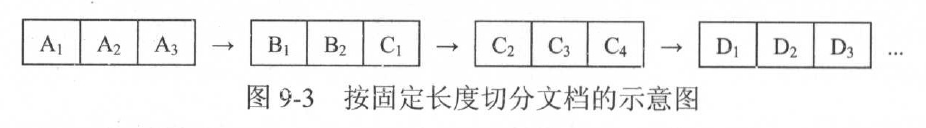

In [12]:
import numpy as np
import tensorflow as tf

TRAIN_DATA = "./ptb.train" # 使用单词编号表示的训练数据
TRAIN_BATCH_SIZE = 20 # 每个batch的大小
TRAIN_NUM_STEP = 35 # 序列长度

# 从文件中读取数据，并返回包含单词编号的数组
def read_data(file_path):
    with open(file_path) as fin:
        # 将整个文档读进一个长字符串
        id_string = ' '.join([line.rstrip() for line in fin.readlines()])
    id_list = [int(w) for w in id_string.split()] # 将读取的单词编号转为整数
    return id_list

def make_batches(id_list, batch_size, num_step):
    # 计算总batch的数量，每个batch包含的单词数量是batch_size * num_step
    num_batches = (len(id_list) - 1) // (batch_size * num_step)
    
    # 如图9-4所示，将数据整理成一个维度为[batch_size, num_batches * num_step]的二维数组
    data = np.array(id_list[: num_batches * batch_size * num_step])
    data = np.reshape(data, [batch_size, num_batches * num_step])
    # 沿着第二个维度将数据切分成num_batches个batch，存入一个数组
    data_batches = np.split(data, num_batches, axis=1)
    
    # 重复上述操作，但是每个位置向右移动一位；这里得到的是RNN每一步输出所需要预测的下一个单词
    label = np.array(id_list[1 : num_batches * batch_size * num_step + 1])
    label = np.reshape(label, [batch_size, num_batches * num_step])
    label_batches = np.split(data, num_batches, axis=1)
    
    # 返回一个长度为num_batches的数组，其中每一项包括一个data矩阵和一个label矩阵
    return list(zip(data_batches, label_batches))

def main():
    train_batches = make_batches(read_data(TRAIN_DATA), TRAIN_BATCH_SIZE, TRAIN_NUM_STEP)
    # 在这里插入模型训练的代码，具体在下一节介绍
    
if __name__ == "__main__":
    main()

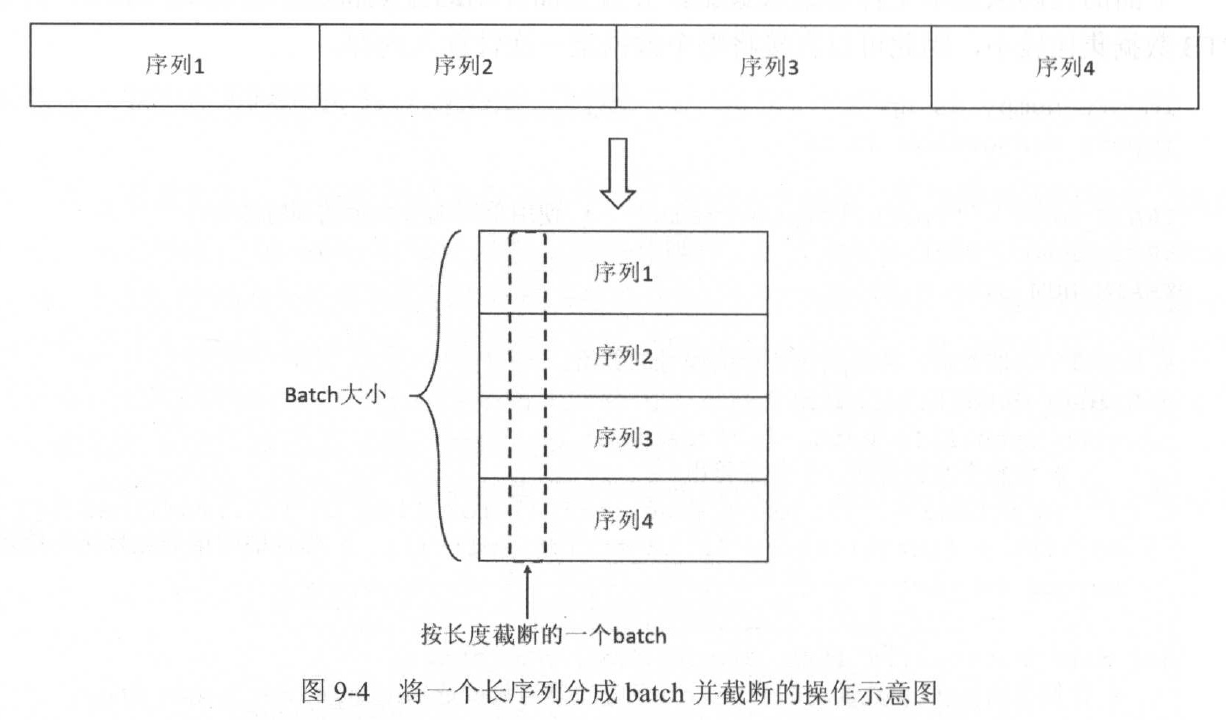

### 9.2.3 基于循环神经网络的神经语言模型

- 在图9-1中可以看到，与第8章介绍的循环神经网络相比，NLP应用中主要多了两个层：词向量层（embedding）和softmax层，下面分别对这两个层进行介绍
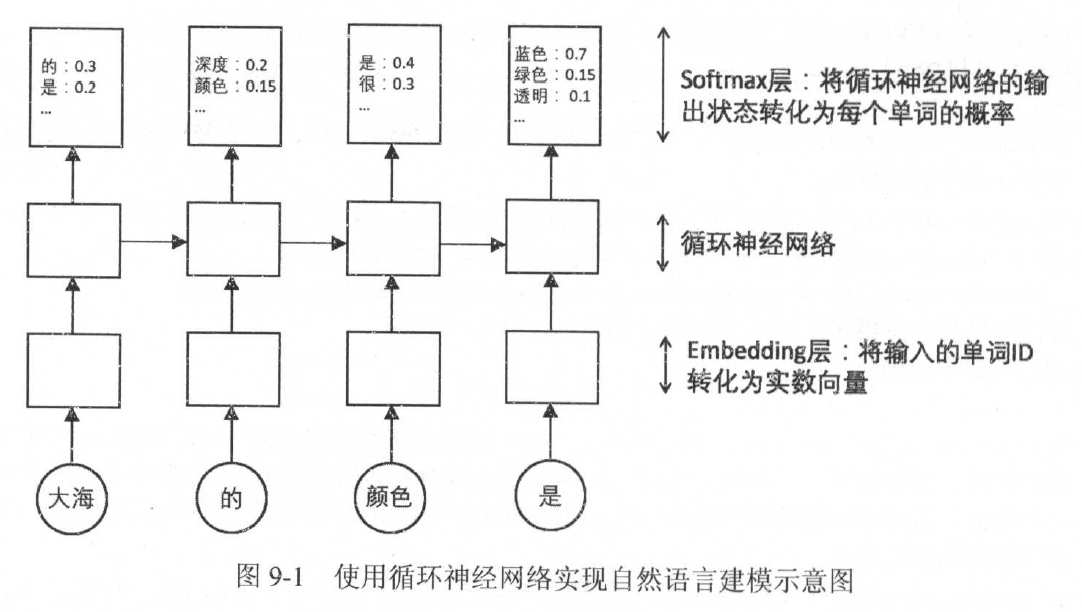

#### 词向量层

- 将单词编号转化为词向量主要有两大作用：1.降低输入的维度：如果不使用词向量层，而直接将单词以one-hot vector的形式输入循环神经网络，那么输入的维度大小将与词汇表大小相同，通常在1000以上，而词向量的维度通常在200~1000之间，这将大大减少循环神经网络的参数数量与计算量；2.增加语义信息
- 假设词向量的维度是EMB_SIZE，词汇表的大小为VOCAB_SIZE，那么所有单词的词向量可以放入一个大小为VOCAB_SIZE * EMB_SIZE的矩阵内，在读取词向量时可以调用tf.nn.embedding_lookup方法

In [13]:
embedding = tf.get_variable("embedding", [VOCAB_SIZE, EMB_SIZE])

# 输出的矩阵比输入数据多一个维度，新增维度大小是EMB_SIZE；在语言模型中，一般input_data的维度是batch_size * num_steps，而输出的input_embedding的维度是batch_size * num_steps *EMB_SIZE
input_embedding = tf.nn.embedding_lookup(embedding, input_data)

NameError: name 'VOCAB_SIZE' is not defined

#### softmax层

- softmax层的作用是将循环神经网络的输出转化为一个单词表中每个单词的输出概率，为此需要有两个步骤：第一，使用一个线性映射将循环神经网络的除数映射为一个维度与词汇表大小相同的向量，这一步的输出叫作logits

In [14]:
# 定义线性映射用到的参数；HIDDEN_SIZE是循环神经网络的隐藏状态维度，VOCAB_SIZE是词汇表的大小
weight = tf.get_variable("weight", [HIDDEN_SIZE, VOCAB_SIZE])
bias = tf.get_variable("bias", [VOCAB_SIZE])
# 计算线性映射；output是RNN的输出，其维度为[batch_size * num_steps, HIDDEN_SIZE]
logits = tf.nn.bias_add(tf.matmul(output, weight), bias)

NameError: name 'HIDDEN_SIZE' is not defined

- 第二，调用softmax方法将logits转化为加和为1的概率；事实上，语言模型的每一步输出都可以看作一个分类问题：在VOCAB_SIZE个可能的类别中决定这一步最可能输出的单词

In [15]:
# prob的维度与logits的维度相同
probs = tf.nn.softmax(logits)

NameError: name 'logits' is not defined

- 模型训练通常并不关心概率的具体取值，而更关心最终的log perplexity，因此可以调用tf.nn.sparse_softmax_cross_entropy_with_logits方法直接从logits计算log perplexity作为损失函数：

In [16]:
# labels是一个大小为[batch_size * num_steps]的一维数组，它包含每个位置正确的单词编号
# logits的维度是[batch_size * num_steps, HIDDEN_SIZE]
# loss的维度与labels相同，代表每个位置上的log perplexity
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf.reshape(self.targets, [-1]), logits=logits)

NameError: name 'self' is not defined

#### 通过共享参数减少参数数量

- softmax层和词向量层的参数数量都与词汇表大小VOCAB_SIZE成正比，由于VOCAB_SIZE的数值通常较大，而HIDDEN_SIZE相对较小，导致softmax和embedding在整个网络的参数数量中占有很大比例；举例，假如VOCAB_SIZE为10000，HIDDEN_SIZE和EMB_SIZE都是512，循环神经网络采用双层LSTM，那么词向量层和softmax层的参数数量均为10000 * 512 = 5120000，而循环网络本身的参数数量仅为2 * 4 * 2 * 512 * 512 = 4194304，少于次向量层和softmax层的参数数量，仅占总参数数量的29%
- 注意，在上面的例子中，词向量层和softmax层的参数数量是相等的，它们都为每一个单词分配了一个长度为512的向量；有研究指出，如果共享词向量层和softmax层的参数，不仅能大幅减少参数数量，还能提高最终模型效果，下面的完整代码样例中实现了这一方法

#### 完整的训练程序

In [1]:
# coding: utf8
import numpy as np
import tensorflow as tf

TRAIN_DATA = "ptb.train"     # 训练数据路径
EVAL_DATA = "ptb.valid"      # 验证数据路径
TEST_DATA = "ptb.test"       # 测试数据路径
HIDDEN_SIZE = 300            # 隐藏层规模；也是embedding向量维度大小；这两个不必保持一致，但h_t和C_t的size都是HIDDEN_SIZE
NUM_LAYERS = 2               # 深层循环神经网络中LSTM结构的层数
VOCAB_SIZE = 10000           # 词典规模
TRAIN_BATCH_SIZE = 20        # 训练数据batch的大小
TRAIN_NUM_STEP = 35          # 训练数据截断长度

EVAL_BATCH_SIZE = 1          # 测试数据batch的大小
EVAL_NUM_STEP = 1            # 测试数据截断长度
NUM_EPOCH = 5                # 使用训练数据的轮数
LSTM_KEEP_PROB = 0.9         # LSTM节点不被dropout的概率
EMBEDDING_KEEP_PROB = 0.9    # 词向量不被dropout的概率
MAX_GRAD_NORM = 5            # 用于控制梯度膨胀的梯度大小上限
SHARE_EMB_AND_SOFTMAX = True # 在softmax层和词向量层之间共享参数

# 通过一个PTBModel类来描述模型，这样方便维护循环神经网络中的状态
class PTBModel(object):
    def __init__(self, is_training, batch_size, num_steps):
        # 记录使用的batch大小和截断长度
        self.batch_size = batch_size
        self.num_steps = num_steps
        
        # 定义每一步的输入和预期输出，两者的维度都是[batch_size, num_steps]
        self.input_data = tf.placeholder(tf.int32, [batch_size, num_steps])
        self.target = tf.placeholder(tf.int32, [batch_size, num_steps])
        
        # 定义使用LSTM结构为循环体结构且使用dropout的深层循环神经网络
        dropout_keep_prob = LSTM_KEEP_PROB if is_training else 1.0
        lstm_cells = [tf.nn.rnn_cell.DropoutWrapper(tf.nn.rnn_cell.BasicLSTMCell(HIDDEN_SIZE), output_keep_prob=dropout_keep_prob) for _ in range(NUM_LAYERS)]
        cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cells)
        
        # 初始化最初的状态，即全零的向量，这个量只在每个epoch初始化第一个batch时使用
        self.initial_state = cell.zero_state(batch_size, tf.float32)
        
        # 定义单词的词向量矩阵
        embedding = tf.get_variable("embedding", [VOCAB_SIZE, HIDDEN_SIZE])
        
        # 将输入单词转化为词向量
        inputs = tf.nn.embedding_lookup(embedding, self.input_data)
        
        # 只在训练时使用dropout
        if is_training:
            inputs = tf.nn.dropout(inputs, EMBEDDING_KEEP_PROB)
            
        # 定义输出列表，这里先将不同时刻LSTM结构的输出收集起来，再一起提供给softmax层
        outputs = []
        state = self.initial_state
        with tf.variable_scope("RNN"):
            for time_step in range(num_steps):
                if time_step > 0:
                    tf.get_variable_scope().reuse_variables()
                    cell_output, state = cell(inputs[:, time_step, :], state)
                    outputs.append(cell_output)
        # 把输出队列展开成[batch, hidden_size*num_steps]的形状，然后再reshape成[batch*num_steps, hidden_size]的形状
        output = tf.reshape(tf.concat(outputs, 1), [-1, HIDDEN_SIZE])
        
        # softmax层：将RNN在每个位置上的输出转化为各个单词的logits
        if SHARE_EMB_AND_SOFTMAX:
            weight = tf.transpose(embedding)
        else:
            weight = tf.get_variable("weight", [HIDDEN_SIZE, VOCAB_SIZE])
        bias = tf.get_variable("bias", [VOCAB_SIZE])
        logits = tf.matmul(output, weight) + bias
        
        # 定义交叉熵损失函数和平均损失
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf.reshape(self.targts, [-1]), logits=logits)
        self.cost = tf.reduce_sum(loss) / batch_size
        self.final_state = state
        
        # 只在训练模型时定义反向传播操作
        if not is_training:
            return
        
        trainable_variable = tf.trainable_variables()
        # 控制梯度大小，定义优化方法和训练步骤
        grads, _ = tf.clip_by_global_norm(tf.gradients(self.cost, trainable_variables), MAX_GRAD_NORM)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=1.0)
        self.train_op = optimizer.apply_gradients(zip(grads, trainable_variables))
        
# 使用给定的模型model在数据data上运行train_op并返回在全部数据上的perplexity值
def run_epoch(session, model, batches, train_op, output_log, step):
    # 计算平均perplexity的辅助变量
    total_costs = 0.0
    iters = 0
    state = session.run(model.initial_states)
    # 训练一个epoch
    for x, y in batches:
        # 在当前batch运行train_op并计算损失值；交叉熵损失函数计算的就是下一个单词为给定单词的概率
        cost, state, _ = session.run([model.cost, model.final_state, train_op], {model.input_data: x, model.targets: y, model.initial_state: state})
        total_costs += cost
        iters += model.num_steps
        
        # 只在训练时输出日志
        if output_log and step % 100 == 0:
            print "After %d steps, perplexity is %.3f" % (step, np.exp(total_costs / iters))
        step += 1
    
    # 返回给定模型在给定数据上的perplexity值
    return step, np.exp(total_costs / iters)

# 从文件中读取数据，并返回包含单词编号的数组
def read_data(file_path):
    with open(file_path) as fin:
        # 将整个文档读进一个长字符串
        id_string = ' '.join([line.rstrip() for line in fin.readlines()])
    id_list = [int(w) for w in id_string.split()] # 将读取的单词编号转为整数
    return id_list

def make_batches(id_list, batch_size, num_step):
    # 计算总batch的数量，每个batch包含的单词数量是batch_size * num_step
    num_batches = (len(id_list) - 1) // (batch_size * num_step)
    
    # 如图9-4所示，将数据整理成一个维度为[batch_size, num_batches * num_step]的二维数组
    data = np.array(id_list[: num_batches * batch_size * num_step])
    data = np.reshape(data, [batch_size, num_batches * num_step])
    # 沿着第二个维度将数据切分成num_batches个batch，存入一个数组
    data_batches = np.split(data, num_batches, axis=1)
    
    # 重复上述操作，但是每个位置向右移动一位；这里得到的是RNN每一步输出所需要预测的下一个单词
    label = np.array(id_list[1 : num_batches * batch_size * num_step + 1])
    label = np.reshape(label, [batch_size, num_batches * num_step])
    label_batches = np.split(data, num_batches, axis=1)
    
    # 返回一个长度为num_batches的数组，其中每一项包括一个data矩阵和一个label矩阵
    return list(zip(data_batches, label_batches))

def main():
    # 定义初始化函数
    initializer = tf.random_uniform_initializer(-0.05, 0.05)
    
    # 定义训练用的循环神经网络模型
    with tf.variable_scope("language_model", reuse=None, initializer=initializer):
        train_model = PTBModel(True, TRAIN_BATCH_SIZE, TRAIN_NUM_STEP)
        
    # 定义测试用的循环神经网络模型，它与train_model共用参数，但是没有dropout
    with tf.variable_scope("language_model", reuse=True, initializer=initializer):
        eval_model = PTBModel(False, EVAL_BATCH_SIZE, EVAL_NUM_STEP)
        
    # 训练模型
    with tf.Session() as session:
        tf.global_variables_initializer().run()
        train_batches = make_batches(read_data(TRAIN_DATA), TRAIN_BATCH_SIZE, TRAIN_NUM_STEP)
        eval_batches = make_batches(read_data(EVAL_DATA), EVAL_BATCH_SIZE, EVAL_NUM_STEP)
        test_batches = make_batches(read_data(TEST_DATA), EVAL_BATCH_SIZE, EVAL_NUM_STEP)
        step = 0
        for i in range(NUM_EPOCH):
            print "In iteration: %d" % (i + 1) 
            step, train_pplx = run_epoch(session, train_model, train_batches, train_model.train_op, True, step)
            print "Epoch: %d Train Perplexity: %.3f" % (i+1, train_pplx)
            _, eval_pplx = run_epoch(session, eval_model, eval_batches, tf.no_op(), False, 0)
            print  "Epoch: %d Eval Perplexity: %.3f" % (i+1, eval_pplx)
        _, test_pplx = run_epoch(session, eval_model, test_batches, tf.no_op(), False, 0)
        print "Test Perplexity: %.3f" % test_pplx
        
if __name__ == "__main__":
    main()

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


ValueError: Variable language_model/RNN/multi_rnn_cell/cell_0/basic_lstm_cell/kernel does not exist, or was not created with tf.get_variable(). Did you mean to set reuse=tf.AUTO_REUSE in VarScope?

## 9.3 神经网络机器翻译


- 上一节介绍的语言模型是很多自然语言处理应用的基石，非常多自然语言处理应用的技术都是基于语言模型，这一节将介绍的机器翻译就是一个例子

### 9.3.1 机器翻译背景与Seq2Seq模型介绍

- 与传统的统计翻译模型相比，2014年提出的循环神经网络Seq2Seq在概念上要简单得多。在统计翻译模型中，模型的训练步骤可以分为预处理、词对齐、短语对齐、抽取短语特征（feature）、训练语言模型、学习特征权重等诸多步骤，而Seq2Seq模型的基本思想非常简单——使用一个循环神经网络读取句子，将整个句子的信息压缩到一个固定维度的编码中，再使用另一个循环神经网络读取这个编码，将其“解压”为目标语言的一个句子，这两个循环神经网络分别称为编码器（Encoder）和解码器（Decoder），这个模型也称为encoder-decoder模型
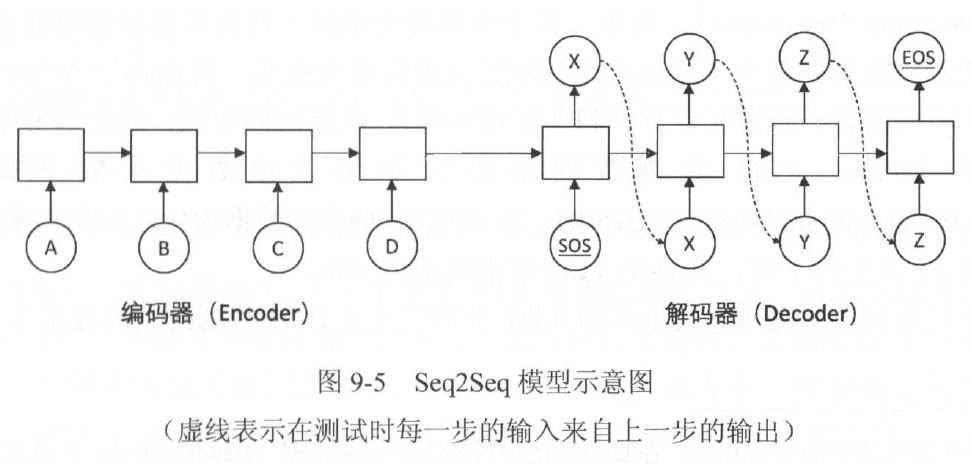

- 解码器部分的结构与语言模型几乎完全相同：输入为单词的词向量，输出为softmax层产生的单词概率，损失函数为log perplexity。事实上，解码器可以理解为一个以输入编码为前提的语言模型（Conditional Language Model）。语言模型中使用的一些技巧，如共享softmax层和词向量的参数，都可以直接应用到Seq2Seq模型的解码器中
- 编码器部分则更为简单，它与解码器一样拥有词向量层和循环神经网络，但是由于在编码阶段并未输出，因此不需要softmax层
- 在训练过程中，编码器顺序读入每个单词的词向量，然后将最终的隐藏状态复制到解码器作为初始状态；解码器的第一个输入时一个特殊的$<sos>$（Start-Of-Sentence）字符，每一步预测的单词时训练数据的目标句子，预测序列的最后一个单词是与语言模型相同的$<eos>$（End-Of-Sentence）字符
- 在机器翻译应用中，在真实应用场景下的测试步骤与语言模型的测试步骤有所不同；上一节介绍过，语言模型中测试的标准是给定目标句子上的perplexity，而机器翻译的测试方法是，让解码器在没有“正确答案”的情况下自主生成一个翻译句子，然后采用人工或自动的方法对翻译句子的质量进行评测；让解码器生成句子的过程也称为“解码”（decoding）；这样的测试方法更贴近于用户实际使用机器翻译产品的体验；在解码过程中，每一步预测的单词中概率最大的单词被选中为这一步的输出，并复制到下一步的输入中

### 9.3.2 机器翻译文本数据的预处理

- 对于语料的预处理，步骤和9.2.1小节中关于PTB数据的预处理基本一致：首先，需要统计语料中出现的单词，为每个单词分配一个ID，将词汇表存入一个vocab文件，然后将文本转化为用单词编号的形式来表示，生成词汇表时，需要注意将$<sos>、<eos>、<unk>$这3个词活动加入，并且要限制词汇表大小，将词频过低的词替换为$<unk>$
- 在PTB数据中，由于句子之间有上下文关联，因此可以直接将连续的句子连接起来称为一个大的段落；而在机器翻译的训练样本中，每个句子对通常是作为独立的数据来训练的，由于每个句子的长短不一致，因此在将这些句子放入同一个batch时，需要将较短的句子补齐到与同batch内最长句子相同的长度，用于填充长度而填入的位置叫做填充（padding），在TensorFlow中，tf.data.Dataset的padded_batch函数提供了这一功能
- 下表给出了一个填充示例，假设一个数据集中有4句话，将它们加入必要的填充并组成大小为2的batch后，得到的batch如下所示
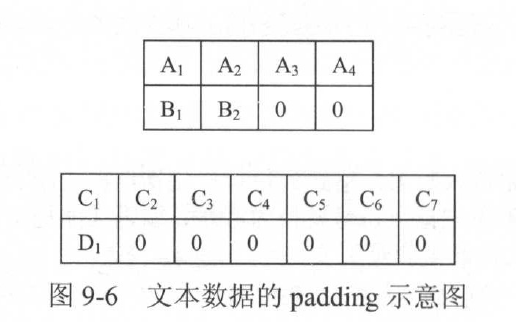
- 循环神经网络在读取数据时会将填充位置的内容与其他内容一样纳入计算，因此为了不让填充影响训练，有两方面需要注意：
- 第一，循环神经网络在读取填充时，应当跳过这一位置的计算；以编码器为例，如果编码器在读取填充时，像正常输入一样处理填充输入，那么在读取$B_1B_200$之后产生的最后一位隐藏状态就和读取$B_1B_2$之后的隐藏状态不同，会产生错误的结果；TensorFlow提供了tf.nn.dynamic_rnn方法来实现这一功能，dynamic_rnn对每一个batch的数据读取两个输入：输入数据的内容（维度为\[batch_size, time\]）和输入数据的长度（维度为\[time\]）。在读取了相应长度的内容后，dynamic_rnn就跳过后面的输入，直接把前一步的计算结果复制到后面的时刻，这样可以保证padding是否存在不影响模型效果
- 另外值得注意的是，使用dynamic_rnn时每个batch的最大序列长度不需要相同，例如在上面的例子中，第一个batch的维度是2\*4，而第二个batch的维度是2\*7，在训练中dynamic_rnn会根据每个batch的最大长度动态展开到需要的层数，这就是它被称为“dynamic”的原因
- 第二，在设计损失函数时需要特别将填充位置的损失的权重设置为0，这样在填充位置产生的预测不会影响梯度的计算

- 下面的代码使用tf.data.Dataset.padded_batch来进行填充和batching，并记录每个句子的序列长度用作dynamic_rnn的输入，与前面PTB的例子不同，这里没有将所有数据读入内存，而是使用Dataset从磁盘动态读取数据

In [1]:
MAX_LEN = 50 # 限定句子的最大单词数量
SOS_ID = 1   # 目标语言词汇表中<sos>的ID

# 使用Dataset从一个文件中读取一个语言的数据；数据的格式为每行一句话，单词已经转化为单词编号
def MakeDataset(file_path):
    dataset = tf.data.TextLineDataset(file_path)
    # 根据空格将单词编号切分开并放入一个一维向量
    dataset = dataset.map(lambda string: tf.string_split([string]).values)
    # 将字符串形式的单词编号转化为整数
    dataset = dataset.map(lambda string: tf.string_to_number(string, tf.int32))
    # 统计每个句子的单词数量，并与句子内容一起放入Dataset中
    dataset = dataset.map(lambda x: (x, tf.size(x)))
    return dataset

# 从源语言文件src_path和目标语言文件trg_path中分别读取数据，并进行填充和batching操作
def MakeSrcTrgDataset(src_path, trg_path, batch_size):
    # 首先分别读取源语言数据和目标语言数据
    src_data = MakeDataset(src_path)
    trg_data = MakeDataset(trg_path)
    # 通过zip操作将两个Dataset合并为一个Dataset，现在每个Dataset中每一项数据ds由4个张量组成：
    # ds[0][0]是源句子
    # ds[0][1]是源句子长度
    # ds[1][0]是目标句子
    # ds[1][1]是目标句子长度
    dataset = tf.data.Dataset.zip((src_data, trg_data))
    
    # 删除内容为空（只包含<eos>的句子和长度过程的句子）
    def FilterLength(src_tuple, trg_tuple):
        ((src_input, src_len), (trg_label, trg_len)) = (src_tuple, trg_tuple)
        src_len_ok = tf.logical_and(tf.greater(src_len, 1), tf.less_equal(src_len, MAX_LEN))
        trg_len_ok = tf.logical_and(tf.greater(src_len, 1), tf.less_equal(src_len, MAX_LEN))
        return tf.logical_and(src_len_ok, trg_len_ok)
    dataset = dataset.filter(FilterLength)
    
    # 从图9-5可知，解码器需要两种格式的目标句子：
    # 1.解码器的输入（trg_input），形式如同"<sos> X Y Z"
    # 2.解码器的目标输出（trg_label），形式如同"X Y Z <eos>"
    # 上面从文件中读到的目标句子是“X Y Z <eos>”的形式，我们需要从中生成"<sos> X Y Z"形式并加入Dataset中
    def MakeTrgInput(src_tuple, trg_tuple):
        ((src_input, src_len), (trg_label, trg_len)) = (src_tuple, trg_tuple)
        trg_input = tf.concat([[SOS_ID], trg_label[:-1]], axis=0)
        return ((src_input, src_len), (trg_input, trg_label, trg_len))
    dataset = dataset.map(MakeTrgInput)
    
    # 随机打乱数据
    dataset = dataset.shuffle(10000)
    
    # 规定填充后输出的数据维度
    padded_shapes = (
            (tf.TensorShape([None]), # 源句子是长度未知的向量
             tf.TensorShape([])),    # 源句子长度是单个数字
            (tf.TensorShape([None]), # 目标句子（解码器输入）是长度未知的向量
             tf.TensorShape([None]), # 目标句子（解码器目标输出）是长度未知的向量
             tf.TensorShape([])))    # 目标句子长度是单个数字
    # 调用padded_batch方法进行batching操作
    batched_dataset = dataset.padded_batch(batch_size, padded_shapes)
    return batched_dataset

### 9.3.3 Seq2Seq模型的代码实现

- 本小节中，模型的训练和测试将分为两个程序来实现；首先讲解模型训练的实现，和9.2节中语言模型的实现相似，也使用一个双层LSTM作为循环神经网络的主体，并在softmax层和词向量层之间共享参数；与9.2节中的语言模型相比，下面代码的主要变化有以下几点：1.增加了一个循环神经网络作为编码器；2.使用Dataset动态读取数据，而不是直接将所有数据读入内存；3.每个batch完全独立，不需要在batch之间传递状态；4.每训练200步便将模型参数保存到一个checkpoint中，之后将讲解怎样从checkpoint中读取模型并对新句子进行翻译

In [2]:
# coding: utf8
import tensorflow as tf

# 假设输入数据已经用9.2.1小节中的方法转换成了单词编号的格式
SRC_TRAIN_DATA = "/path/to/data/train.en" # 源语言输入文件
TRG_TRAIN_DATA = "/path/to/data/train.zh" # 目标语言输入文件
CHECKPOINT_PATH = "/path/to/seq2seq_ckpt" # checkpoint保存路径
HIDDEN_SIZE = 1024                        # LSTM的隐藏层规模
NUM_LAYERS = 2                            # 深层循环神经网络中LSTM结构的层数
SRC_VOCAB_SIZE = 10000                    # 源语言词汇表大小
TRG_VOCAB_SIZE = 4000                     # 目标语言词汇表大小
BATCH_SIZE = 100                          # 训练数据batch的大小
NUM_EPOCH = 5                             # 使用训练数据的轮数
KEEP_PROB = 0.8                           # 节点不被dropout的概率
MAX_GRAD_NORM = 5                         # 用于控制梯度膨胀的梯度大小上限
SHARE_EMB_AND_SOFTMAX = True              # 在softmax层和词向量层之间共享参数

# 定义NMTModel类来描述模型
class NMTModel(object):
    # 在模型的初始化函数中定义模型要用到的变量
    def __init__(self):
        # 定义编码器和解码器所使用的LSTM结构
        self.enc_cell = tf.nn.rnn_cell.MultiRNNCell([tf.nn.rnn_cell.BasicLSTMCell(HIDDEN_SIZE) for i in range(NUM_LAYERS)])
        self.dec_cell = tf.nn.rnn_cell.MultiRNNCell([tf.nn.rnn_cell.BasicLSTMCell(HIDDEN_SIZE) for i in range(NUM_LAYERS)])
        
        # 为源语言和目标语言分别定义词向量
        self.src_embedding = tf.get_variable("src_emb", [SRC_VOCAB_SIZE, HIDDEN_SIZE])
        self.trg_embedding = tf.get_variable("trg_emb", [TRG_VOCAB_SIZE, HIDDEN_SIZE])
        
        # 定义softmax层的变量
        if SHARE_EMB_AND_SOFTMAX:
            self.softmax_weight = tf.transpose(self.trg_embedding)
        else:
            self.softmax_weight = tf.get_variable("weight", [HIDDEN_SIZE, TRG_VOCAB_SIZE])
            self.softmax_bias = tf.get_variable("softmax_bias", [TRG_VOCAB_SIZE])
            
    # 在forward函数中定义模型的前向计算图
    # src_input, src_size, trg_input, trg_label, trg_size分别是上面MakeSrcTrgDataset函数产生的五种张量
    def forward(self, src_input, src_size, trg_input, trg_label, trg_size):
        batch_size = tf.shape(src_input)[0]
        
        # 将输入和输出单词编号转为词向量
        src_emb = tf.nn.embedding_lookup(self.src_embedding, src_input)
        trg_emb = tf.nn.embedding_lookup(self.trg_embedding, trg_input)
        
        # 在词向量上进行dropout
        src_emb = tf.nn.dropout(src_emb, KEEP_PROB)
        trg_emb = tf.nn.dropout(trg_emb, KEEP_PROB)
        
        # 使用dynamic_rnn构造编码器；编码器读取源句子每个位置的词向量，输出最后一步的隐藏状态enc_state；
        # 因为编码器是一个双层LSTM，因此enc_state是一个包含两个LSTMStateTuple类的tuple，每个LSTMStateTuple对应编码器中一层的状态；
        # enc_outputs是顶层LSTM每一步的输出，它的维度是[batch_size, max_time, HIDDEN_SIZE]，seq2seq模型中不需用到enc_outputs，
        # 而后面介绍的attention模型会用到它
        with tf.variable_scope("encoder"):
            enc_outputs, enc_state = tf.nn.dynamic_rnn(self.enc_cell, src_emb, src_size, dtype=tf.float32)
        
        # 使用dynamic_rnn构造解码器；解码器读取目标句子每个位置的词向量，输出的dec_outputs为每一步顶层LSTM的输出，dec_outputs的维度是
        # [batch_size, max_time, HIDDEN_SIZE]；initial_state=enc_state表示用编码器的输出来初始化第一步的隐藏状态
        with tf.variable_scope("decoder"):
            dec_outputs, _ = tf.nn.dynamic_rnn(self.dec_cell, trg_emb, trg_size, initial_state=enc_state)
            
        # 计算解码器每一步的log perplexity，这一步与语言模型的代码相同
        output = tf.reshape(dec_outputs, [-1, HIDDEN_SIZE])
        logits = tf.matmul(output, self.softmax_weight) + self.softmax_bias
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf.reshpe(trg_label, [-1]), logits=logits)
        
        # 在计算平均损失时，需要将填充位置的权重设置为0，以避免无效位置的预测干扰模型的训练
        label_weights = tf.sequence_mask(trg_size, maxlen=tf.shape(trg_label)[1], dtype=tf.float32)
        label_weights = tf.reshape(label_weights, [-1])
        cost = tf.reduce_sum(loss * label_weights)
        cost_per_token = cost / tf.reduce_sum(label_weights)
        
        # 定义反向传播操作，反向操作的实现与语言模型代码相同
        trainable_variables = tf.trainable_variables()
        
        # 控制梯度大小，定义优化方法和训练步骤
        grads = tf.gradients(cost / tf.to_float(batch_size), trainable_variables)
        grads, _ = tf.clip_by_global_norm(grads, MAX_GRAD_NORM)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=1.0)
        train_op = optimizer.apply_gradients(zip(grads, trainable_variables))
        return cost_per_token, train_op

# 使用给定的模型model上训练一个epoch，并返回全局步数；每训练200步便保存一个checkpoint
def run_epoch(session, cost_op, train_op, saver, step):
    # 训练一个epoch；重复训练步骤直至遍历完Dataset中所有数据
    while True:
        try:
            # 运行train_op并计算损失值；训练数据在main()函数中以Dataset方式提供
            cost, _ = session.run([cost_op, train_op])
            if step % 10 == 0:
                print "After %d steps, per token cost is %.3f" % (step, cost)
            # 每200步保存一个checkpoint
            if step % 200 == 0:
                saver.save(session, CHECKPOINT_PATH, global_step=step)
            step += 1
        except tf.errors.OutOfRangeError:
            break
    return step

def main():
    # 定义初始化函数
    initializer = tf.random_uniform_initializer(-0.05, 0.05)
    
    # 定义训练用的循环神经网络模型
    with tf.variable_scope("nmt_model", reuse=None, initializer=initializer):
        train_model = NMTModel()
        
    # 定义输入数据
    data = MakeSrcTrgDataset(SRC_TRAIN_DATA, TRG_TRAIN_DATA, BATCH_SIZE)
    iterator = data.make_initializable_iterator()
    (src, src_size), (trg_input, trg_label, trg_size) = iterator.get_next()
    
    # 定义前向计算图；输入数据以张量形式提供给forward函数
    cost_op, train_op = train_model.forward(src, src_size, trg_input, trg_label, trg_size)
    
    # 训练模型
    saver = tf.train.Saver()
    step = 0
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        for i in range(NUM_EPOCH):
            print "In iteration: %d" % (i+1)
            sess.run(iterator.initializer)
            step = run_epoch(sess, cost_op, train_op, saver, step)
            
if __name__ == "__main__":
    main()

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.


AttributeError: 'NMTModel' object has no attribute 'softmax_bias'

- 上面的程序完成了机器翻译模型的训练步骤，并将训练好的模型保存到checkpoint中，下面讲解怎样从checkpoint中读取模型并对一个新的句子进行翻译，对新输入的句子进行翻译的过程也称为解码（decoding）或推理（inference）
- 在解码过程中，模型只能看到输入句子，却不能看到目标句子；解码器在第一步读取$<sos>$符，预测目标句子的第一个单词，然后需要将这个预测的单词复制到第二步作为输入，再预测第二个单词，直到预测的单词为$<eos>$为止，这个过程需要使用一个循环结构来实现；在TensorFlow中，循环结构是由tf.while_loop来实现的，tf.while_loop的使用方法如下：

In [3]:
# cond是一个函数，负责判断继续执行循环的条件
# loop_body是每个循环体内执行的操作，负责对循环状态进行更新
# init_state为循环的起始状态，它可以包含多个Tensor或者TensorArray
# 返回的结果是循环结束时的循环状态
final_state = tf.while_loop(cond, loop_body, init_state)

NameError: name 'cond' is not defined

In [5]:
import tensorflow as tf

# 读取checkpoint的路径；9000表示是训练程序在第9000步保存的checkpoint
CHECKPOINT_PATH = "/path/to/seq3seq_ckpt-9000"

# 模型参数；必须与训练时的模型参数保持一致
HIDDEN_SIZE = 1024           # LSTM的隐藏层规模
NUM_LAYERS = 2               # 深层循环神经网络中LSTM结构的层数
SRC_VOCAB_SIZE = 10000       # 源语言词汇表大小
TRG_VOCAB_SIZE = 4000        # 目标语言词汇表大小
SHARE_EMB_AND_SOFTMAX = True # 在softmax层和词向量层之间共享参数

# 词汇表中<sos>和<eos>的ID；在解码过程中需要用<sos>作为第一步的输入，并将检查是否是<eos>
SOS_ID = 1
EOS_ID = 2

# 定义NMTModel类来描述模型
class NMTModel(object):
    # 在模型的初始化函数中定义模型要用到的变量
    def __init__(self):
        # 与训练时的__init__函数相同
        # 通常在训练程序和解码程序中复用NMTModel类及其__init__函数，以确保解码时和训练时定义的变量相同
        
    def inference(self, src_input):
        # 虽然输入只有一个句子，但因为dynamic_rnn要求输入是batch的形式，因此这里将输入句子整理为大小为1的batch
        src_size = tf.convert_to_tensor([len(src_input)], dtype=tf.int32)
        src_input = tf.convert_to_tensor([src_input], dtype=tf.int32)
        src_emb = tf.nn.embedding_lookup(self.src_embedding, src_input)
        
        # 使用dynamic_rnn构造编码器，这一步与训练时相同
        with tf.variable_scope("encoder"):
            enc_outputs, enc_state = tf.nn.dynamic_rnn(self.enc_cell, src_emb, src_size, dtype=tf.float32)
        
        # 设置解码的最大步数，这是为了避免在极端情况下出现无限循环问题
        MAX_DEC_LEN = 100
        
        with tf.variable_scope("decoder/rnn/multi_rnn_cell"):
            # 使用一个变长的TensorArray来存储生成的句子
            init_array = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True, clear_after_read=False)
            # 填入第一个单词<sos>作为解码器的输入
            init_array = init_array.write(0, SOS_ID)
            # 构建初始的循环状态；循环状态包含循环神经网络的隐藏状态，保存生成句子的TensorArray，以及记录解码步数的一个整数step
            init_loop_var = (enc_state, init_array, 0)
            
            # tf.while_loop的循环条件：循环直到解码器输出<eos>，或者达到最大步数为止
            def continue_loop_condition(state, trg_ids, step):
                return tf.reduce_all(tf.logical_and(tf.not_equal(trg_ids.read(step), EOS_ID), tf.less(step, MAX_DEC_LEN-1)))
            
            def loop_body(state, trg_ids, step):
                # 读取最后一步输出的单词，并读取其词向量
                trg_input = [trg_ids.read(step)]
                trg_emb = tf.nn.embedding_lookup(self.trg_embedding, trg_input)
                # 这里不使用dynamic_rnn，而是直接调用dec_cell向前计算一步
                dec_outputs, next_state = self.dec_cell.call(state=state, inputs=trg_emb)
                # 计算每个可能的输出单词对应的logit，并选取logit值最大的单词作为这一步的输出
                output = tf.reshape(dec_outputs, [-1, HIDDEN_SIZE])
                logits = (tf.matmul(output, self.softmax_weight) + self.softmax_bias)
                next_id = tf.argmax(logits, axis=1, output_type=tf.int32)
                # 将这一步输出的单词写入循环状态的trg_ids中
                trg_ids = trg_ids.write(step+1, next_id[0])
                return next_state, trg_ids, step+1
        
            # 执行tf.while_loop，返回最终状态
            state, trg_ids, step = tf.while_loop(continue_loop_condition, loop_body, init_loop_var)
            return trg_ids.stack()
    
def main():
    # 定义训练用的循环神经网络模型
    with tf.variable_scope("nmt_model", reuse=None):
        model = NMTModel()
    # 定义一个测试例子；这里的例子是经过预处理后的“This is a test.”
    test_sentence = [90, 13, 9, 689, 4, 2]
    # 建立解码所需的计算图
    output_op = model.inference(test_sentence)
    sess = tf.Session()
    saver = tf.train.Saver()
    saver.restore(sess, CHECKPOINT_PATH)
    # 读取翻译结果
    output = sess.run(output_op)
    print output
    sess.close()
    
if __name__ == "__main__":
    main()

IndentationError: expected an indented block (<ipython-input-5-29db253d1ccf>, line 24)

- 运行以上程序，得到的翻译结果是\[1, 10, 7, 12, 411, 271, 6, 2\]，按中文vocab文件转化为文字，就是"$<sos>$这是一个测试$<eos>$"

### 9.3.4 注意力机制

- 在Seq2Seq模型中，编码器将完整的输入句子压缩到一个维度固定的向量中，然后解码器根据这个向量生成输出句子，当输出句子较长时，这个中间向量难以存储足够的信息，就成为这个模型的一个瓶颈；注意力（Attention）机制就是为了解决这个问题而设计的，注意力机制允许解码器随时查阅输入句子中的部分单词或片段，因此不再需要在中间向量中存储所有信息

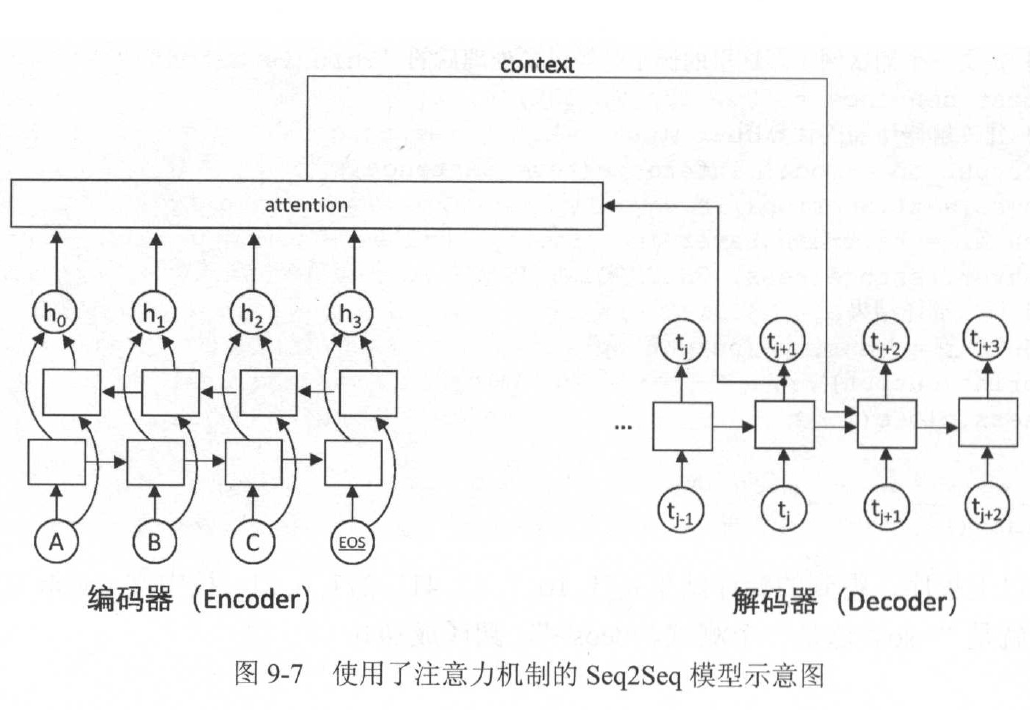
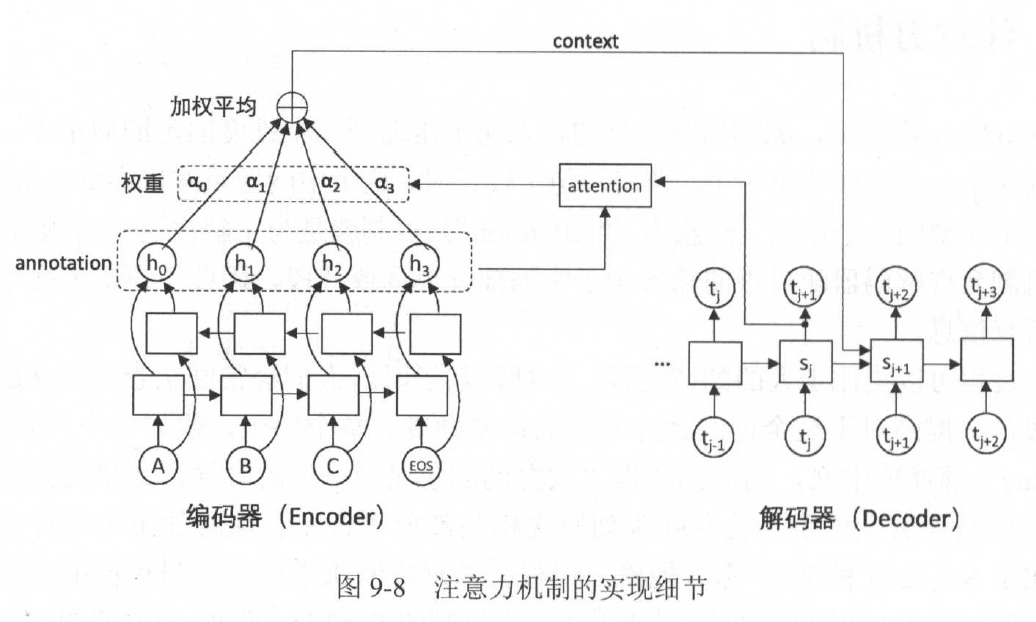

- 下面介绍注意力机制的数学定义，在图9-8中，$h_i$表示编码器在第i个单词上的输出，$s_j$是编码器在预测第j个单词时的状态，计算j时刻的context的方法如下：
$$\alpha_{i,j}=\frac{\exp(e(h_i,s_j))}{\sum_i \exp(e(h_i,s_j))}$$
$$context_j = \sum_i \alpha_{i,j}h_i$$
- 其中$e(h_i,s_j)$是计算原文各单词与当前解码器状态的“相关度”的函数，最常用的$e(h,s)$函数定义是一个带有单个隐藏层的前馈神经网络：
$$e(h,s)=U\tanh (Vh+Ws)$$
其中U，V，W是模型的参数，$e(h,s)$构成了一个包含一个隐藏层的全连接神经网络
- 这个模型是Dzmitry Bahdanau等在第一次提出注意力机制的论文中采用的模型，因此也称为Bahdanau Attention，除此之外，注意力机制还有多种其他设计，如Minh-Thang Luong等提出的$e(h,s)=h^T Ws$，或直接使用两个状态之间的点乘$e(h,s)=h^Ts$，无论$e(h,s)$采用哪个模型，通过softmax计算权重$\alpha$和通过加权平均计算context的方法都是一样的
- 在计算得到第j步的context向量之后，context被加入到j+1时刻作为循环层的输入，假设h的维度是hidden_src，词向量的维度是hidden_emb，那么在计算隐藏状态$s_j$时，输入的维度是hidden_src+hidden_emb；通过context向量，解码器可以在解码的每一步查询最相关的原文信息，从而避免Seq2Seq模型中信息瓶颈问题

- 比较图9-5和图9-7，除增加了注意力机制以外，还可以看到两点不同；第一，编码器采用了一个双向循环网络，虽然Seq2Seq模型中也可以使用双向循环网络作为编码器，但在使用注意力机制时，这一选择将变得尤为重要，这是因为在解码器通过注意力查询一个单词时，通常也需要知道该单词周围的部分信息，如果使用单向循环网络，那么每个单词的annotation就只包含它左边的文字的信息，而不包含它右边的信息，而双向循环网络使得每个单词的annotation可以同时包含左右两侧的信息
- 第二，这里取消了编码器和解码器之间的连接，解码器完全依赖于注意力机制获取原文信息，取消这一连接使得编码器和解码器可以自由选择模型，例如，它们可以选择不同层数、不同维度、不同结构的循环神经网络，可以在编码器中使用双向LSTM，而在解码器使用单向LSTM，甚至可以用卷积网络作为编码器、用循环神经网络作为解码器等
- 注意力机制的实现较为复杂，为了方便开发者，TensorFlow已经提供了几种预置的实现；tf.contrib.seq2seq.AttentionWrapper将解码器的循环神经网络层和注意力层结合，成为一个更高层的循环神经网络，每一步计算的context在相邻解码步骤之间的传递，可以视为一个隐藏状态在相邻时刻之间的传递，将注意力机制封装成循环神经网络后，就可以使用dynamic_rnn调用新的包含注意力的循环神经网络

- 下面的代码在9.3.3小节关于Seq2Seq模型的代码基础上稍作修改，展示了使用AttentionWrapper的方法

In [6]:
# 下面self.enc_cell_fw和self.enc_cell_bw定义了编码器中的前向和后向循环网络
# 它们取代了Seq2Seq样例代码中__init__函数里的self.enc_cell
self.enc_cell_fw = tf.nn.rnn_cell.BasicLSTMCell(HIDDEN_SIZE)
self.enc_cell_bw = tf.nn.rnn_cell.BasicLSTMCell(HIDDEN_SIZE)

# 下面的代码取代了Seq2Seq样例代码中forward函数里的相应部分
with tf.variable_scope("encoder"):
    # 构造编码器时，使用bidirectional_dynamic_rnn构造双向循环网络
    # 双向循环网络的顶层输出enc_outputs是一个包含两个张量的tuple，每个张量的维度都是[batch_size, max_time, HIDDEN_SIZE]，代表两个
    # LSTM在每一步的输出
    enc_outputs, enc_state = tf.nn.bidirectional_dynamic_rnn(self.enc_cell_fw, self.enc_cell_bw, src_emb, src_size, 
                                                            dtype=tf.float32)
    # 将两个LSTM的输出拼接为一个张量
    enc_outputs = tf.concat([enc_outputs[0], enc_outputs[1]], -1)
    
with tf.variable_scope("decoder"):
    # 选择注意力权重的计算模型；BahdanauAttention是使用一个隐藏层的前馈神经网络
    # memory_sequence_length是一位维度为[batch_size]的张量，代表batch中每个句子的长度，
    # Attention需要根据这个信息把填充位置的注意力权重设置为0
    attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(HIDDEN_SIZE, enc_outputs, memory_sequence_length=src_size)
    
    # 将解码器的循环神经网络self.dec_cell和注意力一起封装成更高层的循环神经网络
    attention_cell = tf.contrib.seq2seq.AttentionWrapper(self.dec_cell, attention_mechanism, attention_layer_size=HIDDEN_SIZE)
    
    # 使用attention_cell和dynamic_rnn构造解码器
    # 注意这里没有指定init_state，也就是没有使用编码器的输出来初始化输入，而完全依赖注意力作为信息来源
    dec_outputs, _ = tf.nn.dynamic_rnn(attention_cell, trg_emb, trg_size, dtype=tf.float32)

NameError: name 'self' is not defined

- 注意力机制在很多模型中得到了广泛应用，例如，ConvSeq2Seq模型使用卷积神经网络取代了Seq2Seq模型的循环神经网络，同时仍使用相似的注意力机制在编码器和解码器之间传递信息；Transformer模型既不使用循环神经网络，也不使用卷积神经网络，而完全使用注意力机制在不同神经层之间传递信息，实现了一个仅依靠注意力机制的机器翻译模型并取得了当前最好的效果